<a href="https://colab.research.google.com/github/brainmentorspvtltd/IGDTU_ImageProcessingTF/blob/main/IG_SkinCancerDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

os.environ["KAGGLE_USERNAME"] = "ravikanttyagi"
os.environ["KAGGLE_KEY"] = "095a21c789eb4728fde2b29230033273"

!kaggle datasets download nodoubttome/skin-cancer9-classesisic

100% 785M/786M [00:05<00:00, 200MB/s]
100% 786M/786M [00:05<00:00, 143MB/s]


In [2]:
!unzip skin-cancer9-classesisic.zip

Archive:  skin-cancer9-classesisic.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024707.jpg  
  inflating: Skin cancer 

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# **Exploring Data**

In [8]:
train_path = "dataset/Train"
test_path = "dataset/Test"

In [9]:
class_names = os.listdir(train_path)

In [10]:
class_names

['melanoma',
 'seborrheic keratosis',
 'dermatofibroma',
 'squamous cell carcinoma',
 'nevus',
 'vascular lesion',
 'actinic keratosis',
 'basal cell carcinoma',
 'pigmented benign keratosis']

In [11]:
for name in class_names:
  path = train_path + "/" + name
  n_images = len(os.listdir(path))
  print(name, " : ", n_images)

melanoma  :  438
seborrheic keratosis  :  77
dermatofibroma  :  95
squamous cell carcinoma  :  181
nevus  :  357
vascular lesion  :  139
actinic keratosis  :  114
basal cell carcinoma  :  376
pigmented benign keratosis  :  462


In [12]:
for name in class_names:
  path = test_path + "/" + name
  n_images = len(os.listdir(path))
  print(name, " : ", n_images)

melanoma  :  16
seborrheic keratosis  :  3
dermatofibroma  :  16
squamous cell carcinoma  :  16
nevus  :  16
vascular lesion  :  3
actinic keratosis  :  16
basal cell carcinoma  :  16
pigmented benign keratosis  :  16


In [13]:
random_image = "dataset/Train/dermatofibroma/ISIC_0025314.jpg"

In [14]:
img = cv2.imread(random_image)

In [15]:
img.shape

(450, 600, 3)

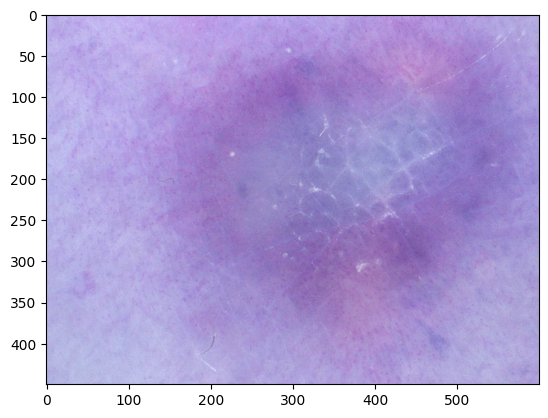

In [16]:
plt.imshow(img)
plt.show()

# **Loading Data - Prepare data**

In [17]:
def load_data(path):
  images_list = []
  labels_list = []
  for i in range(len(class_names)):
    dir_path = path + "/" + class_names[i]
    images = os.listdir(dir_path)
    for j in tqdm(range(len(images))):
      # return path of each image one by one
      img_path = dir_path + "/" + images[j]
      img = cv2.imread(img_path)
      img = cv2.resize(img, (224,224))
      images_list.append(img/255.0)
      labels_list.append(i)

  images_list = np.asarray(images_list)
  labels_list = np.asarray(labels_list)
  return images_list, labels_list

In [18]:
train_image, train_labels = load_data(train_path)

100%|██████████| 462/462 [00:04<00:00, 114.53it/s]


In [19]:
train_image.shape

(2239, 224, 224, 3)

In [20]:
test_images, test_labels = load_data(test_path)

100%|██████████| 16/16 [00:00<00:00, 118.83it/s]


In [89]:
test_images.shape

(118, 224, 224, 3)

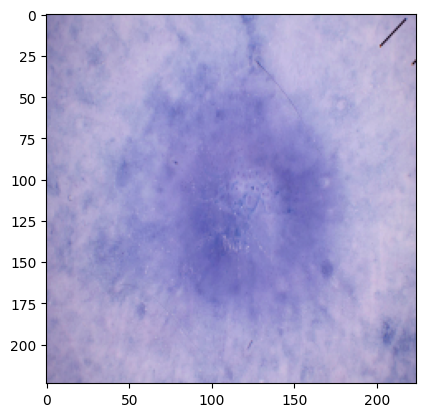

In [21]:
plt.imshow(train_image[564])
plt.show()

# **Data Preprocessing**

In [22]:
train_image[0][0][0]

array([0.52941176, 0.50588235, 0.69411765])

In [23]:
# Normalization
# train_image, test_images = train_image / 255.0, test_images / 255.0

In [24]:
train_image[0][0][0]

array([0.52941176, 0.50588235, 0.69411765])

In [25]:
BUFFER_SIZE = 500
BATCH_SIZE = 32

In [26]:
2239 / 32

69.96875

In [64]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten
from tensorflow.keras.layers import LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.models import Model

In [28]:
train_df = tf.data.Dataset.from_tensor_slices((train_image, train_labels)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_df = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [29]:
train_df

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [72]:
# first we inherit Model class
class MyModel(Model):
  # __init__ - constructor
  def __init__(self):
    # calling parent class constructor
    super().__init__()
    # first convolutional layer
    # 32 - number of filters
    # 3 - 3x3 kernel size (filter window size)
    self.conv_1_1 = Conv2D(64, 3, activation="relu")
    self.conv_1_2 = Conv2D(64, 3, activation="relu")
    # MaxPooling Layer
    self.pool_1 = MaxPool2D(pool_size=(2,2))
    self.conv_2_1 = Conv2D(128, 3, activation="relu")
    self.conv_2_2 = Conv2D(128, 3, activation="relu")
    # MaxPooling Layer
    self.pool_2 = MaxPool2D(pool_size=(2,2))
    self.conv_3_1 = Conv2D(256, 3, activation="relu")
    self.conv_3_2 = Conv2D(256, 3, activation="relu")
    # MaxPooling Layer
    self.pool_3 = MaxPool2D(pool_size=(2,2))
    # Apply flatten
    self.flatten = Flatten()
    # Hidden Layer
    self.hidden_1 = Dense(512)
    self.activation = LeakyReLU()
    self.dropout_1 = Dropout(0.3)
    self.batch_1 = BatchNormalization()
    self.hidden_2 = Dense(256)
    self.dropout_2 = Dropout(0.3)
    self.batch_2 = BatchNormalization()
    self.hidden_3 = Dense(128)
    self.dropout_3 = Dropout(0.3)
    self.batch_3 = BatchNormalization()
    self.hidden_4 = Dense(64)
    self.dropout_4 = Dropout(0.3)
    self.batch_4 = BatchNormalization()
    # Output layer
    self.output_layer = Dense(9, activation="softmax")

  def call(self, data):
    x = self.conv_1_1(data)
    x = self.conv_1_2(x)
    x = self.pool_1(x)
    x = self.conv_2_1(x)
    x = self.conv_2_2(x)
    x = self.pool_2(x)
    x = self.conv_3_1(x)
    x = self.conv_3_2(x)
    x = self.pool_3(x)
    x = self.flatten(x)
    x = self.hidden_1(x)
    x = self.activation(x)
    x = self.dropout_1(x)
    x = self.batch_1(x)
    x = self.hidden_2(x)
    x = self.activation(x)
    x = self.dropout_2(x)
    x = self.batch_2(x)
    x = self.hidden_3(x)
    x = self.activation(x)
    x = self.dropout_3(x)
    x = self.batch_3(x)
    x = self.hidden_4(x)
    x = self.activation(x)
    x = self.dropout_4(x)
    x = self.batch_4(x)
    return self.output_layer(x)

In [83]:
model = MyModel()

In [84]:
# model.summary()

In [85]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
# optimizer = tf.keras.optimizers.Adam()
optimizer = tf.keras.optimizers.RMSprop()

train_acc = tf.keras.metrics.SparseCategoricalAccuracy(name="train_acc")
test_acc = tf.keras.metrics.SparseCategoricalAccuracy(name="test_acc")

train_loss = tf.keras.metrics.Mean(name="train_loss")
test_loss = tf.keras.metrics.Mean(name="test_loss")

In [86]:
# Decorators - we pass function as an argument in another function
# Here @tf.function is a decorator
# Now it means that there is function in tensorflow whose name is "function"
# now when model starts to train then train_step function will be passed as an argument inside tf.function

@tf.function
def train_step(train_images, train_labels):
  # now once we start tensorflow graph then it will initiate process of Gradient Descent
  with tf.GradientTape() as tape:
    # it will execute call() that we have defined in our class
    predictions = model(train_images)
    # then we calculate loss on our training data
    loss = loss_object(train_labels, predictions)

  # Optimization
  # it will keep track of gradients for your computations
  grad = tape.gradient(loss, model.trainable_variables)
  # apply optimization - it will update weights and bias
  optimizer.apply_gradients(zip(grad, model.trainable_variables))

  train_loss(loss)
  train_acc(train_labels, predictions)

In [87]:
@tf.function
def test_step(test_images, test_labels):
  predictions = model(test_images, training=False)
  loss = loss_object(test_labels, predictions)
  test_loss(loss)
  test_acc(test_labels, predictions)

In [88]:
epochs = 50

for epoch in range(epochs):
  train_loss.reset_states()
  train_acc.reset_states()
  test_loss.reset_states()
  test_acc.reset_states()
  for images, labels in train_df:
    train_step(images, labels)

  for images, labels in test_df:
    test_step(images, labels)

  print("Epoch : {} | Train Loss : {:.3f} | Train Acc : {:.3f} | Test Loss : {} | Test Acc : {}".format(epoch,
                                                                                                train_loss.result(),
                                                                                                train_acc.result(),
                                                                                                test_loss.result(),
                                                                                                test_acc.result()))

Epoch : 0 | Train Loss : 1.660 | Train Acc : 0.412 | Test Loss : 3.144728899002075 | Test Acc : 0.1355932205915451
Epoch : 1 | Train Loss : 1.767 | Train Acc : 0.440 | Test Loss : 3.247100353240967 | Test Acc : 0.1355932205915451
Epoch : 2 | Train Loss : 1.647 | Train Acc : 0.423 | Test Loss : 3.057143449783325 | Test Acc : 0.1355932205915451
Epoch : 3 | Train Loss : 1.618 | Train Acc : 0.431 | Test Loss : 2.714380979537964 | Test Acc : 0.1355932205915451
Epoch : 4 | Train Loss : 1.587 | Train Acc : 0.444 | Test Loss : 2.845557689666748 | Test Acc : 0.1355932205915451
Epoch : 5 | Train Loss : 1.587 | Train Acc : 0.432 | Test Loss : 3.0564708709716797 | Test Acc : 0.1355932205915451
Epoch : 6 | Train Loss : 1.575 | Train Acc : 0.440 | Test Loss : 2.846425771713257 | Test Acc : 0.1355932205915451
Epoch : 7 | Train Loss : 1.560 | Train Acc : 0.451 | Test Loss : 3.5685064792633057 | Test Acc : 0.1355932205915451
Epoch : 8 | Train Loss : 1.599 | Train Acc : 0.459 | Test Loss : 3.00473046302

KeyboardInterrupt: ignored